## Total Cost Model Building and Exploration 

This notebook shows the process of building classification models for Total Costs. It shows the performance of models with different bin sizes, different models, and upsampling techniques. This notebook also contains an evaluation of model performance across sub-populations.

In [8]:
import sys
import platform
plat = platform.system()
if plat == 'Windows':
    sys.path.insert(0, '..\src\helpers')
elif plat =='Linux' or plat=='Darwin':
    sys.path.insert(0, '../src/helpers')

First, we will be importing all necessary libraries required for our Random Forest classification, and we will looking at various metrics including the accuracy, precision, and recall.

In [9]:
#Import all needed models
import sys
sys.path.insert(0, '../src/helpers')
sys.path.insert(0, '../src/data')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.metrics import log_loss, f1_score, classification_report, make_scorer, precision_score, recall_score, accuracy_score, confusion_matrix, plot_confusion_matrix
import seaborn as sns
import imblearn
# print(imblearn.__version__)

The below two cells can be run if the *processed data is not present*, as the below will take the raw data, clean and get it ready for processing.

In [10]:
data_file_path = '../data'
all_patient_df = load_data('all', data_file_path)

all


The below two cells must be run at all times in order to bring in the helper functions for the models and additonally clean data further for data modeling.

###### Step 1 - Creating Bins for Total Cost

We will first create different bins for our classifier.

In [12]:
maxcost = all_patient_df['Total Costs'].max()
print("Maximum Total Cost:", maxcost)

#Bin the data by length of stay ranges
bins = [1, 5000, 10000, 15000, 20000, 30000, 50000, 1250000]
labels = ['1 - 5,000', '5,001 - 10,000', '10,001 - 15,000', '15,001 - 20,000'
          , '20,001 - 30,000', '30,001 - 50,000', '50,001 - 1,250,000']

all_patient_df_bins = all_patient_df.copy()
all_patient_df_bins['Total Costs Bin'] = pd.cut(x = all_patient_df_bins['Total Costs'], 
                                                bins = bins, labels = labels, include_lowest = True)
all_patient_df_bins.head(10)

Maximum Total Cost: 389186


,Hospital Service Area,Hospital County,Permanent Facility Id,Age Group,Gender,Race,Ethnicity,Type of Admission,CCSR Diagnosis Code,CCSR Procedure Code,...,APR MDC Code,APR Severity of Illness Code,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Emergency Department Indicator,Total Costs,Total Charges,Length of Stay,Total Costs Bin
0,New York City,Manhattan,1450,3,Female,Black/African American,Not Span/Hispanic,Emergency,659,0,...,19,2,1,Medical,Medicaid,1,35094,99582,15,"30,001 - 50,000"
1,New York City,Manhattan,1454,3,Male,Black/African American,Not Span/Hispanic,Emergency,659,218,...,19,2,1,Medical,Medicaid,1,14151,21292,14,"10,001 - 15,000"
2,New York City,Richmond,1738,3,Male,White,Not Span/Hispanic,Emergency,659,218,...,19,2,1,Medical,Medicare,1,12788,36650,16,"10,001 - 15,000"
3,New York City,Queens,1638,4,Male,Black/African American,Not Span/Hispanic,Emergency,127,0,...,4,2,1,Medical,Medicaid,1,17242,81309,8,"15,001 - 20,000"
4,New York City,Queens,1626,3,Female,Other Race,Not Span/Hispanic,Emergency,659,218,...,19,2,1,Medical,Medicaid,1,5847,11666,7,"5,001 - 10,000"
5,Western NY,Niagara,583,5,Female,White,Not Span/Hispanic,Elective,203,152,...,8,1,1,Surgical,"Managed Care, Unspecified",0,16085,23297,3,"15,001 - 20,000"
6,New York City,Kings,1305,5,Male,White,Not Span/Hispanic,Elective,203,152,...,8,2,2,Surgical,Medicare,0,17515,54804,3,"15,001 - 20,000"
7,New York City,Bronx,1169,5,Female,White,Not Span/Hispanic,Emergency,99,193,...,5,2,2,Medical,Medicare,0,12593,38629,1,"10,001 - 15,000"
8,Central NY,Oneida,599,4,Female,White,Not Span/Hispanic,Emergency,127,192,...,4,3,3,Medical,Medicare,1,26081,73465,24,"20,001 - 30,000"
9,Long Island,Nassau,541,5,Female,White,Not Span/Hispanic,Emergency,127,0,...,4,3,3,Medical,Medicare,1,5892,33878,2,"5,001 - 10,000"


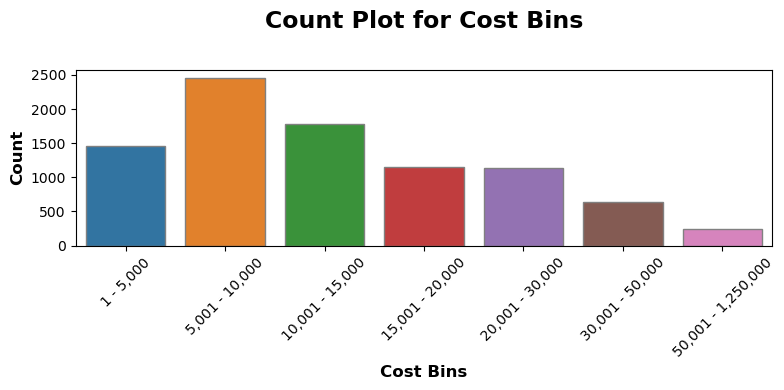

In [13]:
# sns.set_context(rc = {'patch.linewidth': 0.0})
plt.figure(figsize = (8, 4))
plt.title('Count Plot for Cost Bins', fontsize=17, weight='bold', pad=30)
sns.countplot(data=all_patient_df_bins, x="Total Costs Bin", linewidth=1, edgecolor="0.5")
plt.xticks(rotation=45)
plt.xlabel('Cost Bins',fontsize=12, weight='bold')
plt.ylabel('Count',fontsize=12, weight='bold')
plt.tight_layout()
plt.savefig('data/visualizations/CostBins_CountPlot.png')

###### Step 2 - Train model on Hist Gradient Boosting Classfier
This will help us with understanding the Accuracy and F1-scores of the model

In [14]:
X, y, X_train, X_test, y_train, y_test = get_cost_train_test_data(all_patient_df_bins)

model = HistGradientBoostingClassifier()
model.fit(X_train, np.ravel(y_train))
y_pred = model.predict(X_test)
bin1_accuracy = accuracy_score(y_test, y_pred)
bin1_f1_score_macro = f1_score(y_test, y_pred, average='macro')
bin1_f1_score_weighted = f1_score(y_test, y_pred, average='weighted')
cf_matrix = confusion_matrix(y_test, y_pred)
print("Accuracy = ", bin1_accuracy, "\nF1 Macro Score = ", bin1_f1_score_macro, "\nF1 Weighted Score = ", bin1_f1_score_weighted)

Accuracy =  0.3871939736346516 
F1 Macro Score =  0.3281520580031278 
F1 Weighted Score =  0.37566560087139256


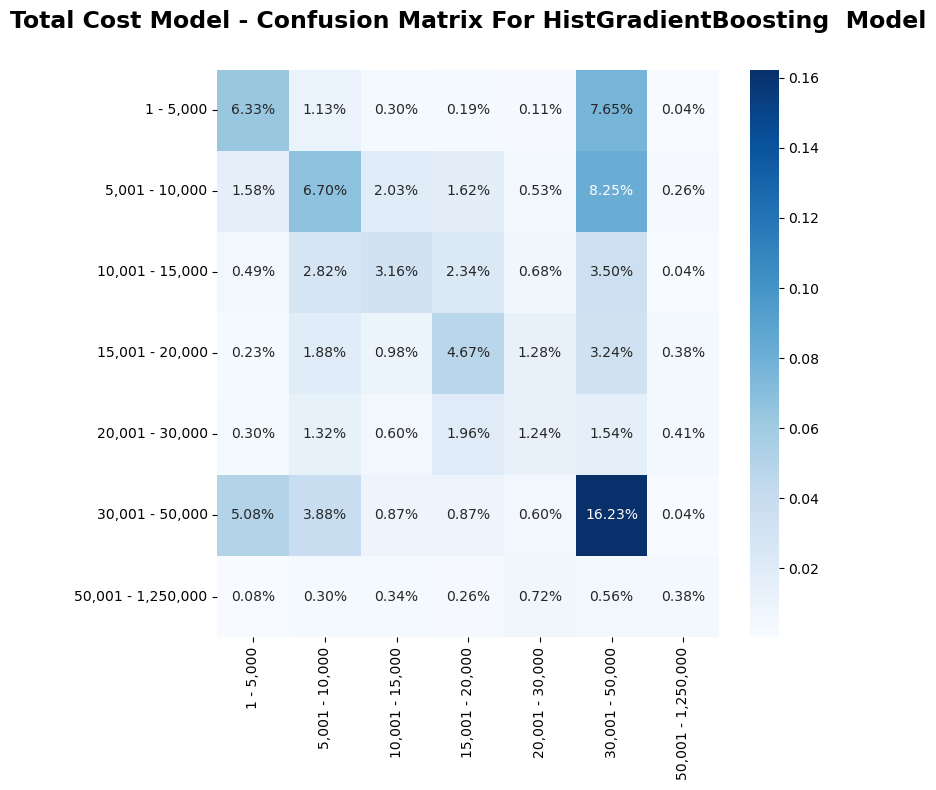

In [15]:
#Visualize the confusion matrix as a heart map
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix), index = [i for i in labels],
                  columns = [i for i in labels])

df_cm.to_csv('data/Cost_ConfusionMatrix.csv')
plt.figure(figsize = (8,8))
plt.title('Total Cost Model - Confusion Matrix For HistGradientBoosting  Model', fontsize=17, weight='bold', pad=30)
sns.heatmap(df_cm, annot=True, fmt='.2%',  cmap='Blues')
plt.tight_layout()
plt.savefig('data/visualizations/Cost_ConfusionMatrix.png')

In [18]:
#Get Gradient Boost Classifier best parameters and best score by sub-population
#Experiment model performance by changing the parameters tested and interations for the RandomizedSearch
gb_scores = []
iterations = 10 #We found the iterations did not affect F1 macro scores much, so we used the default of 10

for drg in ['all', 194.0, 140.0, 750.0, 463.0, 302.0]:
    subpop_df = load_data(drg, data_file_path)
    subpop_df['Total Costs Bin'] = pd.cut(x = subpop_df['Total Costs'], bins = bins, labels = labels, 
                                          include_lowest = True)
    if len(subpop_df) > 30000:
        subpop_df = subpop_df.groupby('Total Costs Bin', group_keys=False).apply(
            lambda x: x.sample(int(np.rint(30000*len(x)/len(subpop_df))))).sample(frac=1).reset_index(drop=True)
        
    X, y, X_train, X_test, y_train, y_test = get_cost_train_test_data(subpop_df)

    random_grid = {'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
                   'learning_rate': [0.1 , 0.5 , 1],
                   'min_samples_leaf': [1, 2, 4],
                   'loss': [ 'auto', 'binary_crossentropy','categorical_crossentropy']}
    
    best_params, best_score = get_best_gbc_params(X_train, y_train, random_grid, iterations)
    gb_scores.append({drg:{
            'best_params': best_params,
            'best_score': best_score
            }
        }
    )

all
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'categorical_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'binary_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'auto' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'bin

/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
9 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py", line 327, in fit
    self._loss = self._get_loss(sample_weight=sample_weight)
  File "/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/skle

{'min_samples_leaf': 2, 'max_depth': 10, 'loss': 'categorical_crossentropy', 'learning_rate': 0.1} 0.3085806018855324
194.0
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'auto' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'auto' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'auto' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'auto' was deprecated in v1.1 and will 

/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
6 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py", line 327, in fit
    self._loss = self._get_loss(sample_weight=sample_weight)
  File "/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/skle

{'min_samples_leaf': 2, 'max_depth': 10, 'loss': 'categorical_crossentropy', 'learning_rate': 0.1} 0.2202181693322586
140.0
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'binary_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'binary_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'binary_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The

/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
9 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py", line 327, in fit
    self._loss = self._get_loss(sample_weight=sample_weight)
  File "/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/skle

{'min_samples_leaf': 2, 'max_depth': 70, 'loss': 'categorical_crossentropy', 'learning_rate': 0.1} 0.2114027152296193
750.0
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'categorical_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'categorical_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'categorical_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: Fut

/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
6 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py", line 327, in fit
    self._loss = self._get_loss(sample_weight=sample_weight)
  File "/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/skle

{'min_samples_leaf': 2, 'max_depth': 60, 'loss': 'auto', 'learning_rate': 0.1} 0.2107091673683027
463.0
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'auto' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'auto' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'auto' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'categorical_crossentropy' was deprecat

/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
9 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py", line 327, in fit
    self._loss = self._get_loss(sample_weight=sample_weight)
  File "/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/skle

{'min_samples_leaf': 2, 'max_depth': 50, 'loss': 'auto', 'learning_rate': 0.1} 0.169606574875759
302.0
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'categorical_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'categorical_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'categorical_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: Fut

/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'categorical_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(


{'min_samples_leaf': 1, 'max_depth': 70, 'loss': 'categorical_crossentropy', 'learning_rate': 0.1} 0.3623119634482636


In [19]:
#Get LogisticRegression best parameters and best score by sub-population
#Experiment model performance by changing the parameters tested and interations for the RandomizedSearch
lr_scores = []
iterations = 10 #We found the iterations did not affect F1 macro scores much, so we used the default of 10

for drg in ['all', 194.0, 140.0, 750.0, 463.0, 302.0]:
    subpop_df = load_data(drg, data_file_path)
    subpop_df['Total Costs Bin'] = pd.cut(x = subpop_df['Total Costs'], bins = bins, 
                                          labels = labels, include_lowest = True)
    if len(subpop_df) > 30000:
        subpop_df = subpop_df.groupby('Total Costs Bin', group_keys=False).apply(
            lambda x: x.sample(int(np.rint(30000*len(x)/len(subpop_df)
                                          )
                                  )
                              )).sample(frac=1).reset_index(drop=True)
        
    X, y, X_train, X_test, y_train, y_test = get_cost_train_test_data(subpop_df)

    random_grid = {'C' : np.logspace(0, 4, num=10),
    'penalty' : ['l1', 'l2'],
    'solver' : ['liblinear'],
    'class_weight': ['balanced', None]}
    
    best_params, best_score = get_best_lr_params(X_train, y_train, random_grid, iterations)
    lr_scores.append({drg:{
            'best_params': best_params,
            'best_score': best_score
            }
        }
    )

all
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 

/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warning

194.0
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 

140.0
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 

750.0
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 

463.0
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 

302.0
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any eff

In [20]:
#Get Random Forest best parameters and best score by sub-population
#Experiment model performance by changing the parameters tested and interations for the RandomizedSearch
rf_scores = []
iterations = 10 #We found the iterations did not affect F1 macro scores much, so we used the default of 10

for drg in ['all', 194.0, 140.0, 750.0, 463.0, 302.0]:
    subpop_df = load_data(drg, data_file_path)
    subpop_df['Total Costs Bin'] = pd.cut(x = subpop_df['Total Costs'], bins = bins, 
                                          labels = labels, include_lowest = True)
    if len(subpop_df) > 30000:
        subpop_df = subpop_df.groupby('Total Costs Bin', group_keys=False).apply(
            lambda x: x.sample(int(np.rint(30000*len(x)/len(subpop_df)
                                          )
                                  )
                              )).sample(frac=1).reset_index(drop=True)
        
    X, y, X_train, X_test, y_train, y_test = get_cost_train_test_data(subpop_df)

    random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 800, num = 15)],
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False],
               'class_weight': ['balanced', 'balanced_subsample']}
    
    best_params, best_score = get_best_rf_params(X_train, y_train, random_grid, iterations)
    
    rf_scores.append({drg:{
            'best_params': best_params,
            'best_score': best_score
            }
        }
    )

all
Fitting 3 folds for each of 10 candidates, totalling 30 fits
0.30806533417288867
194.0
Fitting 3 folds for each of 10 candidates, totalling 30 fits
0.21921689067656577
140.0
Fitting 3 folds for each of 10 candidates, totalling 30 fits
0.2060981010227079
750.0
Fitting 3 folds for each of 10 candidates, totalling 30 fits
0.2160908020405066
463.0
Fitting 3 folds for each of 10 candidates, totalling 30 fits
0.2367993575824493
302.0
Fitting 3 folds for each of 10 candidates, totalling 30 fits
0.36309006461664706


In [21]:
scores_gb_df = pd.DataFrame(columns=['model', 'subpopulation', 'best_params', 'best_scores'])
for item in gb_scores:
    for key, item in item.items():
        scores_gb_df = scores_gb_df.append({'model': 'HistGradientBoost', 'subpopulation': key, 'best_params': item['best_params'], 'best_scores': item['best_score']}, ignore_index=True)
scores_gb_df.head()


/var/folders/z6/k1gp26316czbm7zy5_d3bjvm0000gn/T/ipykernel_76514/1332079419.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_gb_df = scores_gb_df.append({'model': 'HistGradientBoost', 'subpopulation': key, 'best_params': item['best_params'], 'best_scores': item['best_score']}, ignore_index=True)
/var/folders/z6/k1gp26316czbm7zy5_d3bjvm0000gn/T/ipykernel_76514/1332079419.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_gb_df = scores_gb_df.append({'model': 'HistGradientBoost', 'subpopulation': key, 'best_params': item['best_params'], 'best_scores': item['best_score']}, ignore_index=True)
/var/folders/z6/k1gp26316czbm7zy5_d3bjvm0000gn/T/ipykernel_76514/1332079419.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat in

,model,subpopulation,best_params,best_scores
0,HistGradientBoost,all,"{'min_samples_leaf': 2, 'max_depth': 10, 'loss...",0.308581
1,HistGradientBoost,194.0,"{'min_samples_leaf': 2, 'max_depth': 10, 'loss...",0.220218
2,HistGradientBoost,140.0,"{'min_samples_leaf': 2, 'max_depth': 70, 'loss...",0.211403
3,HistGradientBoost,750.0,"{'min_samples_leaf': 2, 'max_depth': 60, 'loss...",0.210709
4,HistGradientBoost,463.0,"{'min_samples_leaf': 2, 'max_depth': 50, 'loss...",0.169607


In [22]:
scores_lr_df = pd.DataFrame(columns=['model', 'subpopulation', 'best_params', 'best_scores'])
for item in lr_scores:
    for key, item in item.items():
        scores_lr_df = scores_lr_df.append({'model': 'LogRegression', 'subpopulation': key, 'best_params': item['best_params'], 'best_scores': item['best_score']}, ignore_index=True)
scores_lr_df.head()


/var/folders/z6/k1gp26316czbm7zy5_d3bjvm0000gn/T/ipykernel_76514/2915300335.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_lr_df = scores_lr_df.append({'model': 'LogRegression', 'subpopulation': key, 'best_params': item['best_params'], 'best_scores': item['best_score']}, ignore_index=True)
/var/folders/z6/k1gp26316czbm7zy5_d3bjvm0000gn/T/ipykernel_76514/2915300335.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_lr_df = scores_lr_df.append({'model': 'LogRegression', 'subpopulation': key, 'best_params': item['best_params'], 'best_scores': item['best_score']}, ignore_index=True)
/var/folders/z6/k1gp26316czbm7zy5_d3bjvm0000gn/T/ipykernel_76514/2915300335.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

,model,subpopulation,best_params,best_scores
0,LogRegression,all,"{'solver': 'liblinear', 'penalty': 'l2', 'clas...",0.279725
1,LogRegression,194.0,"{'solver': 'liblinear', 'penalty': 'l1', 'clas...",0.208910
2,LogRegression,140.0,"{'solver': 'liblinear', 'penalty': 'l2', 'clas...",0.184037
3,LogRegression,750.0,"{'solver': 'liblinear', 'penalty': 'l2', 'clas...",0.192609
4,LogRegression,463.0,"{'solver': 'liblinear', 'penalty': 'l1', 'clas...",0.174494


In [23]:
scores_rf_df = pd.DataFrame(columns=['model', 'subpopulation', 'best_params', 'best_scores'])
for item in rf_scores:
    for key, item in item.items():
        scores_rf_df = scores_rf_df.append({'model': 'RandomForest', 'subpopulation': key, 'best_params': item['best_params'], 'best_scores': item['best_score']}, ignore_index=True)
scores_rf_df.head()


/var/folders/z6/k1gp26316czbm7zy5_d3bjvm0000gn/T/ipykernel_76514/2731067456.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_rf_df = scores_rf_df.append({'model': 'RandomForest', 'subpopulation': key, 'best_params': item['best_params'], 'best_scores': item['best_score']}, ignore_index=True)
/var/folders/z6/k1gp26316czbm7zy5_d3bjvm0000gn/T/ipykernel_76514/2731067456.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_rf_df = scores_rf_df.append({'model': 'RandomForest', 'subpopulation': key, 'best_params': item['best_params'], 'best_scores': item['best_score']}, ignore_index=True)
/var/folders/z6/k1gp26316czbm7zy5_d3bjvm0000gn/T/ipykernel_76514/2731067456.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  s

,model,subpopulation,best_params,best_scores
0,RandomForest,all,"{'n_estimators': 800, 'min_samples_split': 10,...",0.308065
1,RandomForest,194.0,"{'n_estimators': 150, 'min_samples_split': 10,...",0.219217
2,RandomForest,140.0,"{'n_estimators': 500, 'min_samples_split': 5, ...",0.206098
3,RandomForest,750.0,"{'n_estimators': 100, 'min_samples_split': 10,...",0.216091
4,RandomForest,463.0,"{'n_estimators': 350, 'min_samples_split': 5, ...",0.236799


In [24]:
pd.options.display.float_format = "{:,.2f}".format
randomized_search_results = pd.concat([scores_gb_df,scores_lr_df, scores_rf_df])
randomized_search_results.to_csv('data/Cost Best Params_various models.csv')
randomized_search_results

,model,subpopulation,best_params,best_scores
0,HistGradientBoost,all,"{'min_samples_leaf': 2, 'max_depth': 10, 'loss...",0.31
1,HistGradientBoost,194.00,"{'min_samples_leaf': 2, 'max_depth': 10, 'loss...",0.22
2,HistGradientBoost,140.00,"{'min_samples_leaf': 2, 'max_depth': 70, 'loss...",0.21
3,HistGradientBoost,750.00,"{'min_samples_leaf': 2, 'max_depth': 60, 'loss...",0.21
4,HistGradientBoost,463.00,"{'min_samples_leaf': 2, 'max_depth': 50, 'loss...",0.17
5,HistGradientBoost,302.00,"{'min_samples_leaf': 1, 'max_depth': 70, 'loss...",0.36
0,LogRegression,all,"{'solver': 'liblinear', 'penalty': 'l2', 'clas...",0.28
1,LogRegression,194.00,"{'solver': 'liblinear', 'penalty': 'l1', 'clas...",0.21
2,LogRegression,140.00,"{'solver': 'liblinear', 'penalty': 'l2', 'clas...",0.18
3,LogRegression,750.00,"{'solver': 'liblinear', 'penalty': 'l2', 'clas...",0.19


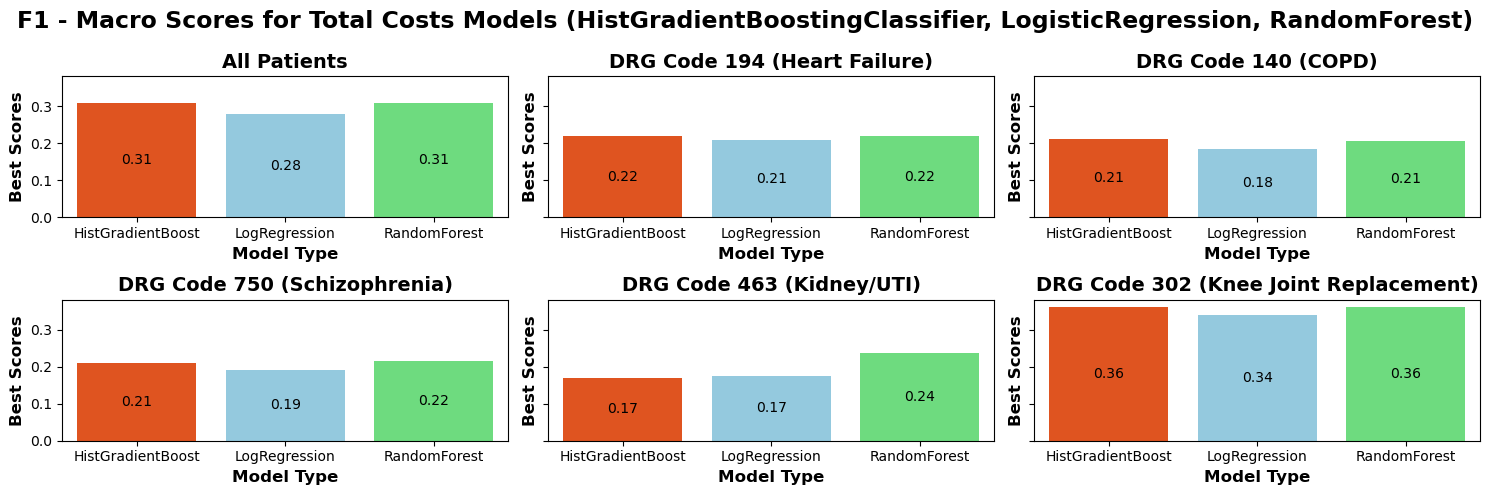

In [25]:
#Create visualization for each subpopulation for each model
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(15,5), sharey=True)

fig.subplots_adjust(hspace=0.7, wspace=0.175)


fig.suptitle('F1 - Macro Scores for Total Costs Models (HistGradientBoostingClassifier, LogisticRegression, RandomForest)',  fontsize=17, weight='bold')

all_patients = randomized_search_results[randomized_search_results['subpopulation'] == 'all']
heart_patients = randomized_search_results[randomized_search_results['subpopulation'] == 194.0]
copd_patients = randomized_search_results[randomized_search_results['subpopulation'] == 140.0]
schizophrenia_patients = randomized_search_results[randomized_search_results['subpopulation'] == 750.0]
kidney_patients = randomized_search_results[randomized_search_results['subpopulation'] == 463.0]
knee_rep_patients = randomized_search_results[randomized_search_results['subpopulation'] == 302.0]

sns.barplot(ax=axes[0, 0], x=all_patients['model'], y=all_patients['best_scores'], palette=['orangered', 'skyblue','#5CED73'])
axes[0, 0].set_title('All Patients',fontsize=14, weight='bold')
axes[0, 0].set_xlabel('Model Type',fontsize=12, weight='bold')
axes[0, 0].set_ylabel('Best Scores',fontsize=12, weight='bold')
axes[0, 0].bar_label(axes[0,0].containers[0], label_type='center', fmt='%.2f')

sns.barplot(ax=axes[0, 1], x=heart_patients['model'], y=heart_patients['best_scores'], palette=['orangered', 'skyblue','#5CED73'])
axes[0, 1].set_title('DRG Code 194 (Heart Failure)',fontsize=14, weight='bold')
axes[0, 1].set_xlabel('Model Type',fontsize=12, weight='bold')
axes[0, 1].set_ylabel('Best Scores',fontsize=12, weight='bold')
axes[0, 1].bar_label(axes[0,1].containers[0], label_type='center', fmt='%.2f')

sns.barplot(ax=axes[0, 2], x=copd_patients['model'], y=copd_patients['best_scores'], palette=['orangered', 'skyblue','#5CED73'])
axes[0, 2].set_title('DRG Code 140 (COPD)',fontsize=14, weight='bold')
axes[0, 2].set_xlabel('Model Type',fontsize=12, weight='bold')
axes[0, 2].set_ylabel('Best Scores',fontsize=12, weight='bold')
axes[0, 2].bar_label(axes[0,2].containers[0], label_type='center', fmt='%.2f')

sns.barplot(ax=axes[1, 0], x=schizophrenia_patients['model'], y=schizophrenia_patients['best_scores'], palette=['orangered', 'skyblue','#5CED73'])
axes[1, 0].set_title('DRG Code 750 (Schizophrenia)',fontsize=14, weight='bold')
axes[1, 0].set_xlabel('Model Type',fontsize=12, weight='bold')
axes[1, 0].set_ylabel('Best Scores',fontsize=12, weight='bold')
axes[1, 0].bar_label(axes[1, 0].containers[0], label_type='center', fmt='%.2f')

sns.barplot(ax=axes[1, 1], x=kidney_patients['model'], y=kidney_patients['best_scores'], palette=['orangered', 'skyblue','#5CED73'])
axes[1, 1].set_title('DRG Code 463 (Kidney/UTI)',fontsize=14, weight='bold')
axes[1, 1].set_xlabel('Model Type',fontsize=12, weight='bold')
axes[1, 1].set_ylabel('Best Scores',fontsize=12, weight='bold')
axes[1, 1].bar_label(axes[1,1].containers[0], label_type='center', fmt='%.2f')

sns.barplot(ax=axes[1, 2], x=knee_rep_patients['model'], y=knee_rep_patients['best_scores'], palette=['orangered', 'skyblue','#5CED73'])
axes[1, 2].set_title('DRG Code 302 (Knee Joint Replacement)',fontsize=14, weight='bold')
axes[1, 2].set_xlabel('Model Type',fontsize=12, weight='bold')
axes[1, 2].set_ylabel('Best Scores',fontsize=12, weight='bold')
axes[1, 2].bar_label(axes[1, 2].containers[0],label_type='center', fmt='%.2f')
plt.tight_layout()
plt.savefig('data/visualizations/Cost_PerfomanceAcrossModels.png')


It looks like for most models, the HistGradientBoostingClassifier does almost the same as the Random Forest Classifier but does slightly better than the LogisticRegression model in for all subpopulations and all patients. Let's train each subpopulation on their best parameters for HistGradientBoostingClassifier model.

In [27]:
final_model_scores = []

for drg in ['all', 194.0, 140.0, 750.0, 463.0, 302.0]:
    subpop_df = load_data(drg, data_file_path)
    subpop_df['Total Costs Bin'] = pd.cut(x = subpop_df['Total Costs'], bins = bins, 
                                          labels = labels, include_lowest = True)      
    X, y, X_train, X_test, y_train, y_test = get_cost_train_test_data(subpop_df)

    best_params = scores_gb_df.loc[(scores_gb_df['model']=='HistGradientBoost') & 
                                   (scores_gb_df['subpopulation']==drg)]['best_params'].values[0]
    model_scores = get_cost_model_scores(best_params, X_train, X_test, y_train, y_test)
    final_model_scores.append({
        'Population': drg,
        'Accuracy Score': model_scores[0],
        'F1_score_macro': model_scores[1],
        'F1_score_weighted': model_scores[2],
        'Model':'HistGradientBoost'
    })

final_results_df = pd.DataFrame(final_model_scores)

all
Training model


/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'categorical_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(


Getting model scores
194.0
Training model


/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'categorical_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(


Getting model scores
140.0
Training model


/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'categorical_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(


Getting model scores
750.0
Training model


/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'auto' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(


Getting model scores
463.0
Training model


/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'auto' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(


Getting model scores
302.0
Training model


/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'categorical_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(


Getting model scores


In [28]:
final_results_df
final_results_df.to_csv('data/HGB_Subpop_Scores.csv')

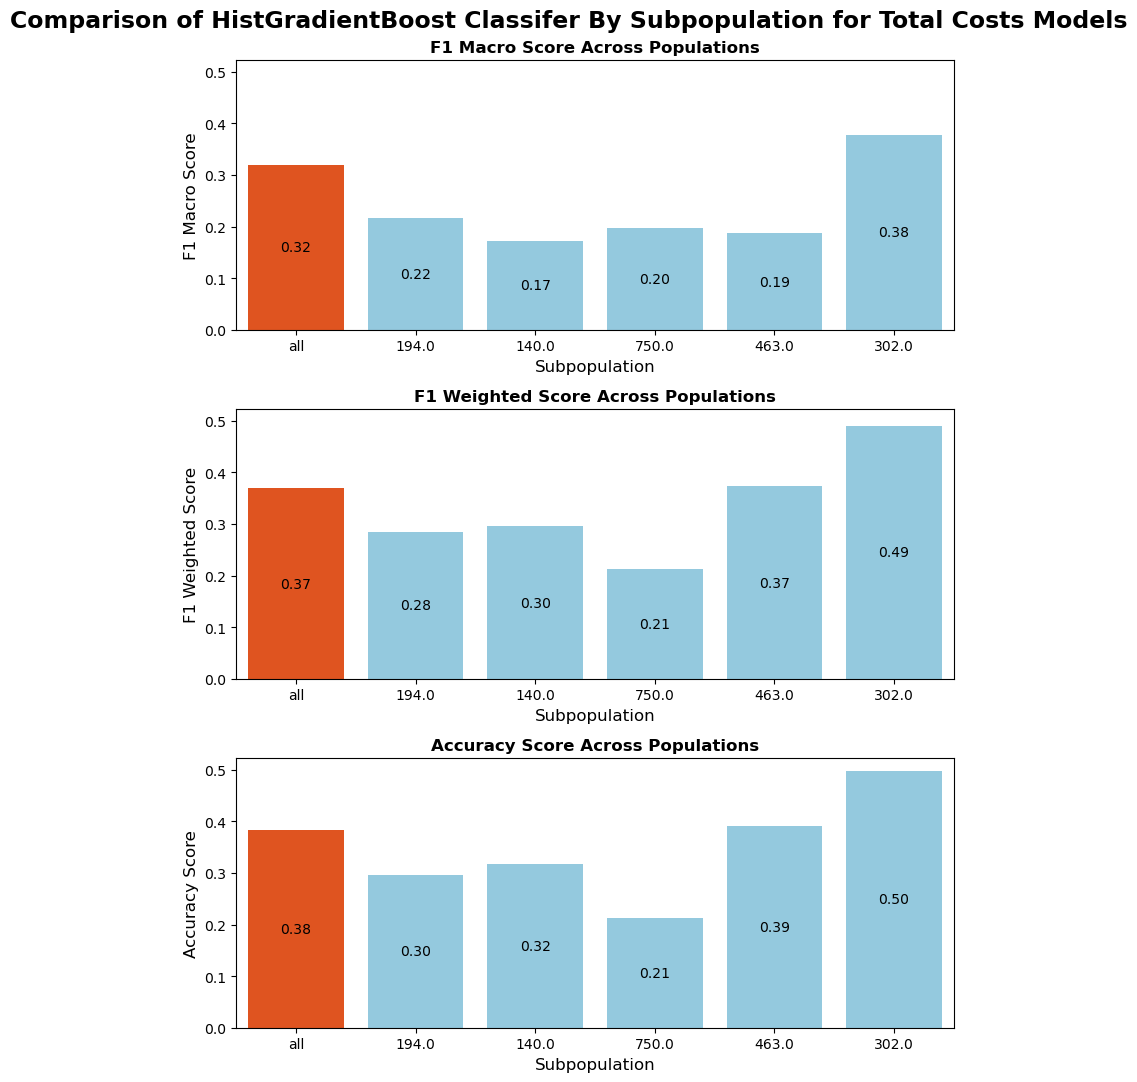

In [29]:
#Visualize the results
#Build visualization comparing random forest model performance of all populations
colors = ['orangered' if (x == 'all') else 'skyblue' for x in final_results_df['Population'].values]

fig, axes = plt.subplots(3, 1, figsize=(8, 11), sharey=True)
fig.subplots_adjust(hspace=0.45, wspace=0.25)
fig.suptitle('Comparison of HistGradientBoost Classifer By Subpopulation for Total Costs Models', fontsize=17, weight='bold')

sns.barplot(ax=axes[0], x=final_results_df['Population'], y=final_results_df['F1_score_macro'], palette=colors)
axes[0].set_xlabel('Subpopulation', fontsize=12)
axes[0].set_ylabel('F1 Macro Score', fontsize=12)
axes[0].bar_label(axes[0].containers[0], label_type='center',fmt='%.2f')
axes[0].set_title('F1 Macro Score Across Populations', fontsize=12, weight='bold')

sns.barplot(ax=axes[1], x=final_results_df['Population'], y=final_results_df['F1_score_weighted'], palette=colors)
axes[1].set_xlabel('Subpopulation', fontsize=12)
axes[1].set_ylabel('F1 Weighted Score', fontsize=12)
axes[1].bar_label(axes[1].containers[0], label_type='center',fmt='%.2f')
axes[1].set_title('F1 Weighted Score Across Populations', fontsize=12, weight='bold')

sns.barplot(ax=axes[2], x=final_results_df['Population'], y=final_results_df['Accuracy Score'], palette=colors)
axes[2].set_xlabel('Subpopulation', fontsize=12)
axes[2].set_ylabel('Accuracy Score', fontsize=12)
axes[2].bar_label(axes[2].containers[0], label_type='center', fmt='%.2f')
axes[2].set_title('Accuracy Score Across Populations', fontsize=12, weight='bold')

plt.tight_layout()
plt.savefig('data/visualizations/Cost_Performance_HistGBC.png')

From the visualization above, it can be seen that for F1 macro scores the model built on all conditions of interest outperforms models trained only on patients with a specific DRG code with the exception of Knee replacement patients.
<br /><br />
Let's also compare performance with a dummy classifier which predicts the majority class every time and a dummy classifier which selects a class at random.

In [30]:
#Get dummy model performance on all the population datasets
final_model_scores = []

#all population
for drg in ['all', 194.0, 140.0, 750.0, 463.0, 302.0]:
    print(drg)
    subpop_df = load_data(drg, data_file_path)
    subpop_df['Total Costs Bin'] = pd.cut(x = subpop_df['Total Costs'], bins = bins, 
                                          labels = labels, include_lowest = True) 
    X, y, X_train, X_test, y_train, y_test = get_cost_train_test_data(subpop_df)
    
    most_freq_dummy_scores = get_dummy_scores("most_frequent", X_train, X_test, y_train, y_test)

    final_model_scores.append({
        'Population': drg,
        'Model': 'DummyClassifier - Most Frequent',
        'Accuracy Score': most_freq_dummy_scores[0],
        'F1_score_macro': most_freq_dummy_scores[1],
        'F1_score_weighted': most_freq_dummy_scores[2]
    })

    random_dummy_scores = get_dummy_scores("uniform", X_train, X_test, y_train, y_test)

    final_model_scores.append({
        'Population': drg,
        'Model': 'DummyClassifier - Random',
        'Accuracy Score': random_dummy_scores[0],
        'F1_score_macro': random_dummy_scores[1],
        'F1_score_weighted': random_dummy_scores[2]
    })

all
all
194.0
194.0
140.0
140.0
750.0
750.0
463.0
463.0
302.0
302.0


In [31]:
final_scores_df = pd.DataFrame(final_model_scores)
final_results_with_dummy_df = pd.concat([final_results_df, final_scores_df], ignore_index=True)
final_results_with_dummy_df
final_results_with_dummy_df.to_csv('data/HGB_vs_Dummy.csv')
final_results_with_dummy_df

,Population,Accuracy Score,F1_score_macro,F1_score_weighted,Model
0,all,0.38,0.32,0.37,HistGradientBoost
1,194.00,0.30,0.22,0.28,HistGradientBoost
2,140.00,0.32,0.17,0.30,HistGradientBoost
3,750.00,0.21,0.20,0.21,HistGradientBoost
4,463.00,0.39,0.19,0.37,HistGradientBoost
5,302.00,0.50,0.38,0.49,HistGradientBoost
6,all,0.27,0.06,0.11,DummyClassifier - Most Frequent
7,all,0.13,0.12,0.14,DummyClassifier - Random
8,194.00,0.34,0.07,0.17,DummyClassifier - Most Frequent
9,194.00,0.15,0.13,0.17,DummyClassifier - Random


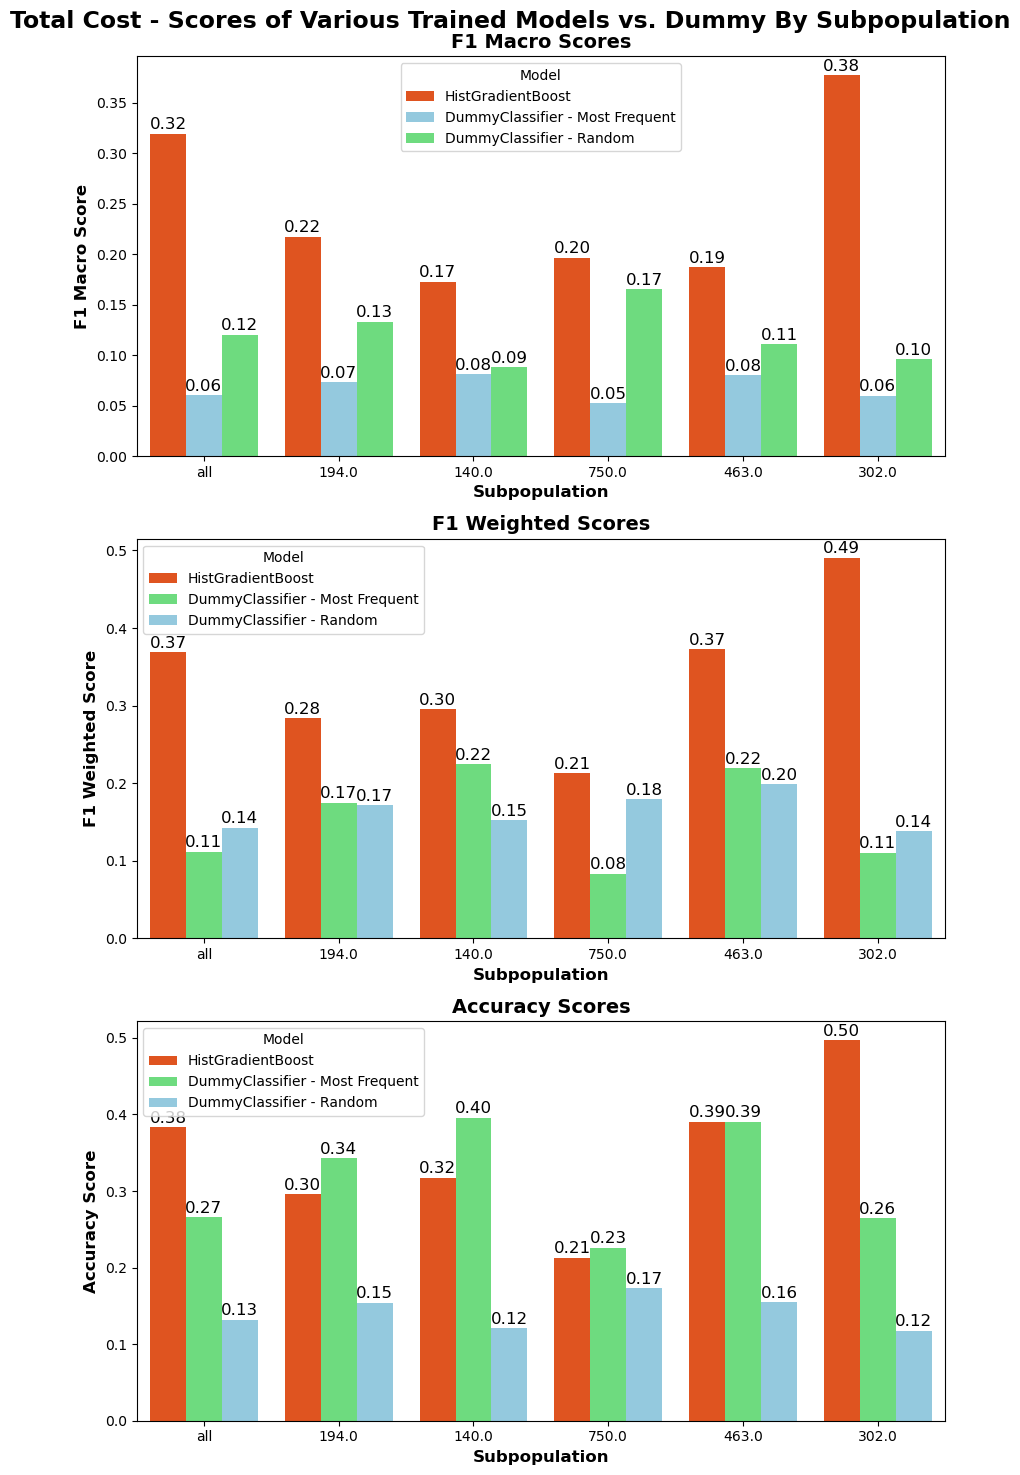

In [32]:
#Plot dummy classifiers vs rf model performance for each population
fig, axes = plt.subplots(3, 1, figsize=(9, 15))
fig.subplots_adjust(hspace=0.45, wspace=0.25)
fig.suptitle('Total Cost - Scores of Various Trained Models vs. Dummy By Subpopulation', fontsize=17, weight = 'bold')

sns.barplot(ax=axes[0], data=final_results_with_dummy_df, x="Population", y="F1_score_macro", 
            hue="Model",palette= ['orangered','skyblue', '#5CED73'])
axes[0].set_xlabel('Subpopulation', fontsize=12,weight = 'bold')
axes[0].set_ylabel('F1 Macro Score', fontsize=12,weight = 'bold')
axes[0].set_title('F1 Macro Scores',fontsize=14, weight = 'bold')

sns.barplot(ax=axes[1], data=final_results_with_dummy_df, x="Population", y="F1_score_weighted", 
            hue="Model",palette= ['orangered','#5CED73', 'skyblue', '#5CED73'])
axes[1].set_xlabel('Subpopulation', fontsize=12,weight = 'bold')
axes[1].set_ylabel('F1 Weighted Score', fontsize=12,weight = 'bold')
axes[1].set_title('F1 Weighted Scores',fontsize=14, weight = 'bold')

sns.barplot(ax=axes[2], data=final_results_with_dummy_df, x="Population", y="Accuracy Score", 
            hue="Model",palette= ['orangered', '#5CED73','skyblue', '#5CED73'])
axes[2].set_xlabel('Subpopulation', fontsize=12,weight = 'bold')
axes[2].set_ylabel('Accuracy Score', fontsize=12,weight = 'bold')
axes[2].set_title('Accuracy Scores',fontsize=14, weight = 'bold')

for ax1 in [axes[0], axes[1], axes[2]]:
    for c in ax1.containers:
        # set the bar label
        ax1.bar_label(c, fmt='%.2f', padding=1, fontsize=12)

plt.tight_layout()
plt.savefig('data/visualizations/Cost_HGB_vs_Dummy.png')



The models do outperform the dummy models, especially when comparing the F1 Macro score. However, overall we can see that the F1 macro scores are still fairly low for the trained models.

As a next step, we will be performing Oversampling, because of the performance time of this, it has been commented out.

In [ ]:
from imblearn.over_sampling import SMOTE

In [97]:
## Commented out since this takes a long time to run

# oversample_scores = []

# oversample = SMOTE()

# best_params = scores_gb_df.loc[(scores_gb_df['model']=='HistGradientBoost') & (scores_gb_df['subpopulation']=='all')]['best_params'].values[0]

# subpop_df = load_data('all', data_file_path)
# subpop_df['Total Costs Bin'] = pd.cut(x = subpop_df['Total Costs'], bins = bins, 
#                                           labels = labels, include_lowest = True)

# X, y, X_train, X_test, y_train, y_test = get_cost_train_test_data(subpop_df)

# X_train_resample, y_train_resample = oversample.fit_resample(X_train, y_train)

# oversampled_model = train_cost_model(best_params, X_train_resample, y_train_resample)

# oversample_scores.append({
#     'Population': 'all',
#     'Model': 'Upsampled',
#     'Accuracy Score': model_scores[0],
#     'F1_score_macro': model_scores[1],
#     'F1_score_weighted': model_scores[2]
# })

# final_results_df = final_results_df.append(oversample_scores)
# final_results_df

'''
Population	Accuracy Score	F1_score_macro	F1_score_weighted	Model
0	all	0.44	0.37	0.42	HistGradientBoost
1	194.00	0.39	0.27	0.34	HistGradientBoost
2	140.00	0.43	0.23	0.39	HistGradientBoost
3	750.00	0.30	0.25	0.27	HistGradientBoost
4	463.00	0.48	0.23	0.43	HistGradientBoost
5	302.00	0.62	0.47	0.60	HistGradientBoost
0	all	0.62	0.47	0.60	Upsampled
'''

all


/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:23: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/Hospital_Inpatient_Discharges_17_18_cleaned.csv')


       Hospital Service Area Hospital County  Permanent Facility Id  \
0              Hudson Valley     Westchester               1,061.00   
1              Hudson Valley     Westchester               1,061.00   
2              Hudson Valley     Westchester               1,072.00   
3              Hudson Valley        Sullivan                 971.00   
4              Hudson Valley        Sullivan                 971.00   
...                      ...             ...                    ...   
420987         New York City          Queens               1,629.00   
420988         New York City          Queens               1,629.00   
420989          Finger Lakes         Ontario                 676.00   
420990         New York City           Bronx               3,058.00   
420991         New York City           Bronx               1,169.00   

          Age Group  Gender                    Race          Ethnicity  \
0          30 to 49    Male                   White  Not Span/Hispanic   

/Users/srilekhas/Documents/srilekha/SL/School/University of Michigan - Grad/medficient-main/notebooks/../src/helpers/data_cleaners.py:23: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/Hospital_Inpatient_Discharges_17_18_cleaned.csv')


Training model


/Users/srilekhas/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1823: FutureWarning: The loss 'auto' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
/var/folders/z6/k1gp26316czbm7zy5_d3bjvm0000gn/T/ipykernel_67977/761000241.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results_df = final_results_df.append(oversample_scores)


,Population,Accuracy Score,F1_score_macro,F1_score_weighted,Model
0,all,0.44,0.37,0.42,HistGradientBoost
1,194.00,0.39,0.27,0.34,HistGradientBoost
2,140.00,0.43,0.23,0.39,HistGradientBoost
3,750.00,0.30,0.25,0.27,HistGradientBoost
4,463.00,0.48,0.23,0.43,HistGradientBoost
5,302.00,0.62,0.47,0.60,HistGradientBoost
0,all,0.62,0.47,0.60,Upsampled


In [125]:
final_results_df
final_results_upsampled.transpose()

,0,0
Population,all,all
Accuracy Score,0.44,0.62
F1_score_macro,0.37,0.47
F1_score_weighted,0.42,0.60
Model,HistGradientBoost,Upsampled


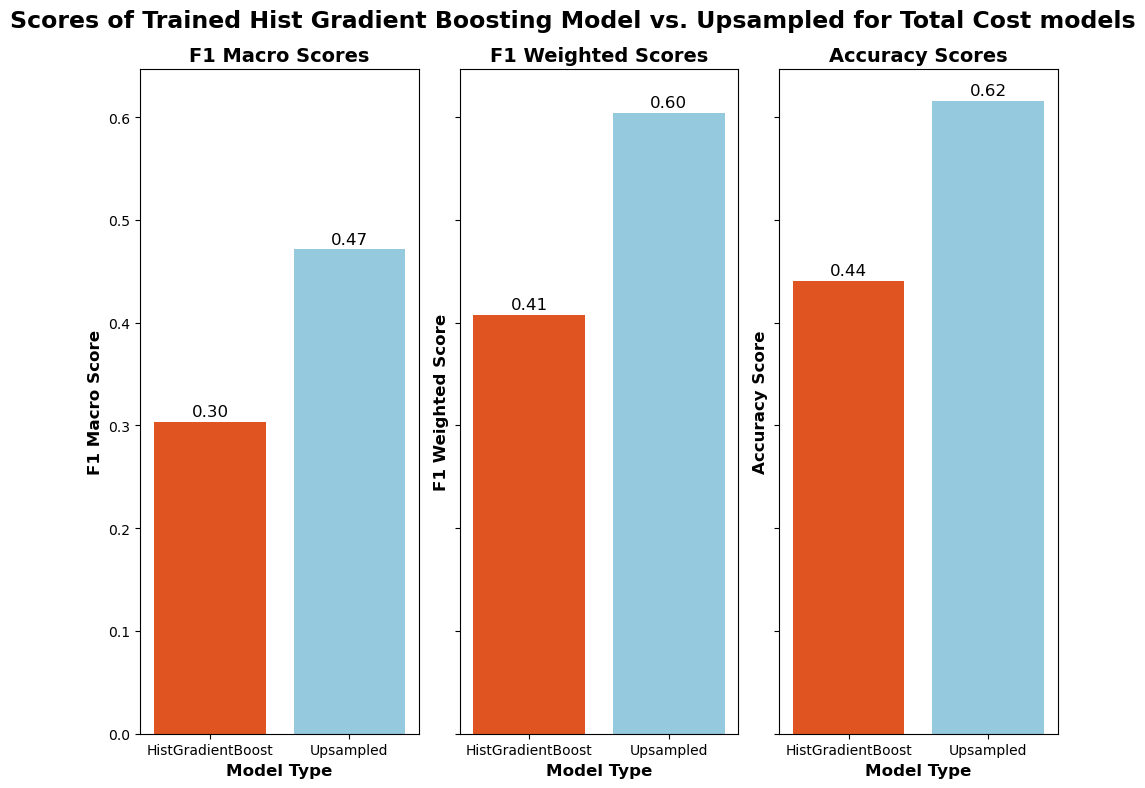

In [130]:
final_results_df.to_csv('data/Cost_HistGB_Oversampling.csv')
#Plot oversampling
fig, axes = plt.subplots(1, 3, figsize=(10, 8),sharey=True)
fig.subplots_adjust(hspace=0.45, wspace=0.25)
fig.suptitle('Scores of Trained Hist Gradient Boosting Model vs. Upsampled for Total Cost models', fontsize=17, weight='bold')

final_results_upsampled = final_results_df[final_results_df['Population'] == 'all']
sns.barplot(ax=axes[0], data=final_results_df, x="Model", y="F1_score_macro", palette= ['orangered', 'skyblue'], ci=None)
axes[0].set_xlabel('Model Type', fontsize=12,weight='bold')
axes[0].set_ylabel('F1 Macro Score', fontsize=12,weight='bold')
axes[0].bar_label(axes[0].containers[0], fmt='%.2f', padding=2, fontsize=12)
axes[0].set_title('F1 Macro Scores',fontsize=14,weight='bold')
axes[0].tick_params(axis='x')

sns.barplot(ax=axes[1], data=final_results_df, x="Model", y="F1_score_weighted", palette= ['orangered', 'skyblue'], ci=None)
axes[1].set_xlabel('Model Type', fontsize=12,weight='bold')
axes[1].set_ylabel('F1 Weighted Score', fontsize=12,weight='bold')
axes[1].bar_label(axes[1].containers[0], fmt='%.2f', padding=2, fontsize=12)
axes[1].set_title('F1 Weighted Scores',fontsize=14,weight='bold')
axes[1].tick_params(axis='x',)

sns.barplot(ax=axes[2], data=final_results_df, x="Model", y="Accuracy Score", palette= ['orangered', 'skyblue'], ci=None)
axes[2].set_xlabel('Model Type', fontsize=12,weight='bold')
axes[2].set_ylabel('Accuracy Score', fontsize=12,weight='bold')
axes[2].bar_label(axes[2].containers[0], fmt='%.2f', padding=2, fontsize=12)
axes[2].set_title('Accuracy Scores',fontsize=14,weight='bold')
axes[2].tick_params(axis='x')
plt.tight_layout()
plt.savefig('data/visualizations/Cost_upsampled_vs_original.png')